In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("dark")

import warnings
warnings.filterwarnings('ignore')

In [30]:
df = pd.read_csv('data/train_sample.csv')
df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [26]:
print("Unique items in each feature: ")
print("ip: ", len(set(df['ip'])))
print("app: ", len(set(df['app'])))
print("device: ", len(set(df['device'])))
print("os: ", len(set(df['os'])))
print("channel: ", len(set(df['channel'])))

Unique items in each feature: 
ip:  34857
app:  161
device:  100
os:  130
channel:  161


In [31]:
import category_encoders as ce


# Year and month are ignored because they have same values among all the records in the dataset(2017, 11)
# dayofweek is ignored due to high correlation (exactly the same) with feature 'day'
def feature_handler(df):
    df['click_time'] = pd.to_datetime(df['click_time'])
    # df['year'] = df['click_time'].dt.year
    # df['month'] = df['click_time'].dt.month
    df['day'] = df['click_time'].dt.day
    df['hour'] = df['click_time'].dt.hour
    df['min'] = df['click_time'].dt.minute
    df['sec'] = df['click_time'].dt.second
    #df['day_of_week'] = df['click_time'].dt.dayofweek

    df.drop(['click_time', 'attributed_time'], inplace=True, axis=1)

    return df

def cat_encoding(df, encoder=None):
    cat = ['ip', 'app', 'device', 'os', 'channel']

    if encoder is None:
        encoder = ce.CountEncoder(cols=cat)
        encoder.fit(df[cat])
        
    df = df.join(encoder.transform(df[cat]).add_suffix('_count'))
    
    df.drop(cat, inplace=True, axis=1)

    return df, encoder

In [32]:
from sklearn.model_selection import train_test_split

X = df.drop('is_attributed', axis=1)
y = df['is_attributed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(80000, 7) (20000, 7) (80000,) (20000,)


In [33]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X_train, X_test = feature_handler(X_train), feature_handler(X_test)
X_train, encoder = cat_encoding(X_train)
X_test, _ = cat_encoding(X_test, encoder)

scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

print(X_train.shape, X_test.shape)

(80000, 9) (20000, 9)


In [19]:
X_train.head()

,day,hour,min,sec,ip_count,app_count,device_count,os_count,channel_count
61074,7,2,5,17,1,4271,75473,19123,1559
8843,8,5,43,57,6,1572,75473,19123,951
62123,9,7,7,18,2,6877,75473,536,615
68491,9,8,9,31,3,1620,75473,19123,1596
37068,7,18,42,57,3,4271,75473,72,1459


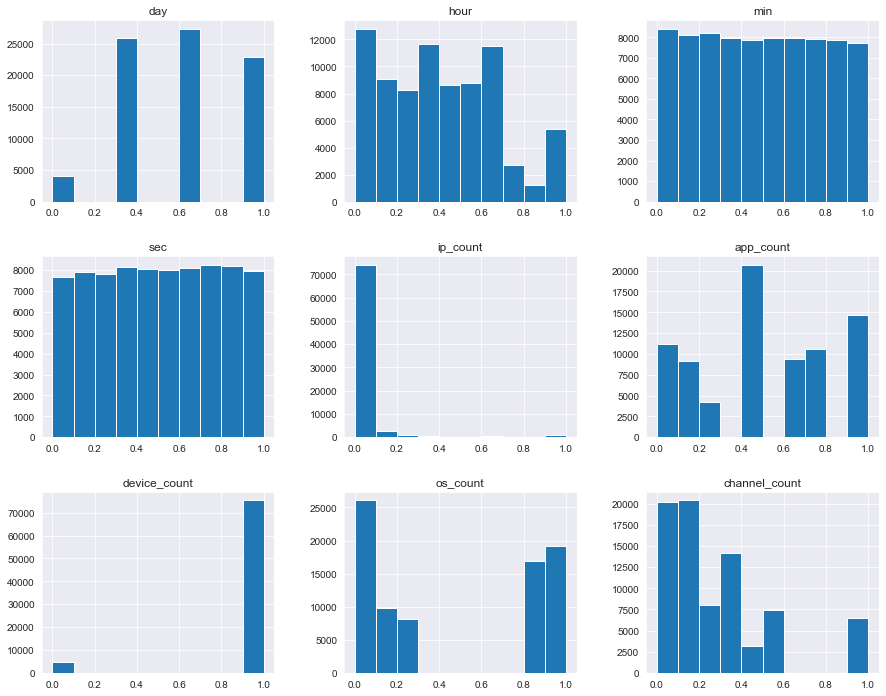

In [86]:
X_train.hist(figsize=(15, 12))
plt.show()

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from collections import Counter
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.decomposition import PCA

# Handeling imbalanced data

In [89]:
print(y_train.value_counts())
print(y_test.value_counts())

0    79818
1      182
Name: is_attributed, dtype: int64
0    19955
1       45
Name: is_attributed, dtype: int64


#### Undersampling

In [7]:
from imblearn.under_sampling import NearMiss

ns = NearMiss(0.5)
X_train_ns, y_train_ns = ns.fit_resample(X_train, y_train)
print('Number of classes before fit: {}'.format(Counter(y_train)))
print('Number of classes after fit: {}'.format(Counter(y_train_ns)))

Number of classes before fit: Counter({0: 79818, 1: 182})
Number of classes after fit: Counter({0: 364, 1: 182})


#### Oversampling

In [8]:
from imblearn.over_sampling import RandomOverSampler

os = RandomOverSampler(0.5)
X_train_os, y_train_os = os.fit_resample(X_train, y_train)
print('Number of classes before fit: {}'.format(Counter(y_train)))
print('Number of classes after fit: {}'.format(Counter(y_train_os)))

Number of classes before fit: Counter({0: 79818, 1: 182})
Number of classes after fit: Counter({0: 79818, 1: 39909})


#### SMOTETomek

In [43]:
from imblearn.combine import SMOTETomek

sm = SMOTETomek(0.5)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
print('Number of classes before fit: {}'.format(Counter(y_train)))
print('Number of classes after fit: {}'.format(Counter(y_train_sm)))

Number of classes before fit: Counter({0: 79818, 1: 182})
Number of classes after fit: Counter({0: 79817, 1: 39908})


### Decision Boundary

In [10]:
def plot_decision_boundary(clf, X, y, name, figsize, do_pca=False, rep=0.02):
    if not do_pca:
        selector = RFE(clf, n_features_to_select=2)
        X_selected = pd.DataFrame(selector.fit_transform(X, y))
        features = selector.get_feature_names_out()
        print(features)
        X_selected.columns = features
    else:
        pca = PCA(n_components=2)
        X_selected = pd.DataFrame(pca.fit_transform(X, y))
        features = [0, 1]
        X_selected.columns = features

        # features = ['app_count', 'channel_count']
        # X_selected = X[features]
        

    clf.fit(X_selected, y)
    
    x_min, x_max = X_selected[features[0]].min() - 0.05, X_selected[features[0]].max() + 0.05 
    y_min, y_max = X_selected[features[1]].min() - 0.05, X_selected[features[1]].max() + 0.05

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, rep), np.arange(y_min, y_max, rep)
    )

    plt.figure(figsize=figsize)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    colors = ['red', 'blue']
    labels = ['not downloaded', 'downloaded']
    for lab in range(0, 2):
        idx = np.where(y == lab)
        plt.scatter(
            X_selected[features[0]].values[idx],
            X_selected[features[1]].values[idx],
            c=colors[lab],
            label=labels[lab],
            cmap=plt.cm.RdYlBu,
            edgecolor="black",
            s=50,
            marker='o',
            alpha=0.3
        )

    plt.title('Decision Boundary for {}'.format(name))
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.legend(loc='best')
    plt.show()

## Logistic Regression

In [45]:
grid = {
    'C': 10.0 ** np.arange(-2, 3),
}
cv = KFold(n_splits=5, random_state=None, shuffle=False)

In [46]:
def logreg(X, y):
    logreg_model = LogisticRegression()
    clf = GridSearchCV(logreg_model, grid, cv=cv, n_jobs=-1, scoring='f1_macro')
    clf.fit(X, y)
    
    y_pred = clf.predict(X_test)
    print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
    print('Accuracy score: ', accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    y_prob = clf.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
    score = roc_auc_score(y_test, y_prob[:, 1])

    return fpr, tpr, score, clf

In [133]:
logreg(X_train, y_train)

Confusion matrix: 
 [[19955     0]
 [   45     0]]
Accuracy score:  0.99775
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19955
           1       0.00      0.00      0.00        45

    accuracy                           1.00     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       1.00      1.00      1.00     20000



In [128]:
logreg(X_train_ns, y_train_ns)

Confusion matrix: 
 [[ 2347 17608]
 [   24    21]]
Accuracy score:  0.1184
              precision    recall  f1-score   support

           0       0.99      0.12      0.21     19955
           1       0.00      0.47      0.00        45

    accuracy                           0.12     20000
   macro avg       0.50      0.29      0.11     20000
weighted avg       0.99      0.12      0.21     20000



In [27]:
fpr_logreg, tpr_logreg, score_logreg, clf_logreg = logreg(X_train_os, y_train_os)

Confusion matrix: 
 [[18363  1592]
 [    7    38]]
Accuracy score:  0.92005
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     19955
           1       0.02      0.84      0.05        45

    accuracy                           0.92     20000
   macro avg       0.51      0.88      0.50     20000
weighted avg       1.00      0.92      0.96     20000



In [47]:
logreg(X_train_sm, y_train_sm)

Confusion matrix: 
 [[18391  1564]
 [    7    38]]
Accuracy score:  0.92145
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     19955
           1       0.02      0.84      0.05        45

    accuracy                           0.92     20000
   macro avg       0.51      0.88      0.50     20000
weighted avg       1.00      0.92      0.96     20000



(array([0.00000000e+00, 5.01127537e-05, 5.01127537e-05, 9.52142320e-04,
        9.52142320e-04, 1.00225507e-03, 1.00225507e-03, 2.00451015e-03,
        2.00451015e-03, 2.25507392e-03, 2.25507392e-03, 2.50563768e-03,
        2.50563768e-03, 3.30744174e-03, 3.30744174e-03, 4.51014783e-03,
        4.51014783e-03, 5.56251566e-03, 5.56251566e-03, 6.26409421e-03,
        6.26409421e-03, 1.04234528e-02, 1.04234528e-02, 1.15760461e-02,
        1.15760461e-02, 1.16762716e-02, 1.16762716e-02, 1.19268354e-02,
        1.19268354e-02, 1.31796542e-02, 1.31796542e-02, 1.35304435e-02,
        1.35304435e-02, 1.39814583e-02, 1.39814583e-02, 1.60360812e-02,
        1.60360812e-02, 1.60861939e-02, 1.60861939e-02, 1.91931847e-02,
        1.91931847e-02, 2.01954397e-02, 2.01954397e-02, 2.09471310e-02,
        2.09471310e-02, 2.24004009e-02, 2.24004009e-02, 2.30017539e-02,
        2.30017539e-02, 2.46554748e-02, 2.46554748e-02, 2.92658482e-02,
        2.92658482e-02, 3.00175395e-02, 3.00175395e-02, 3.086945

In [14]:
clf_logreg.best_estimator_

LogisticRegression(C=10.0)

['app_count' 'channel_count']


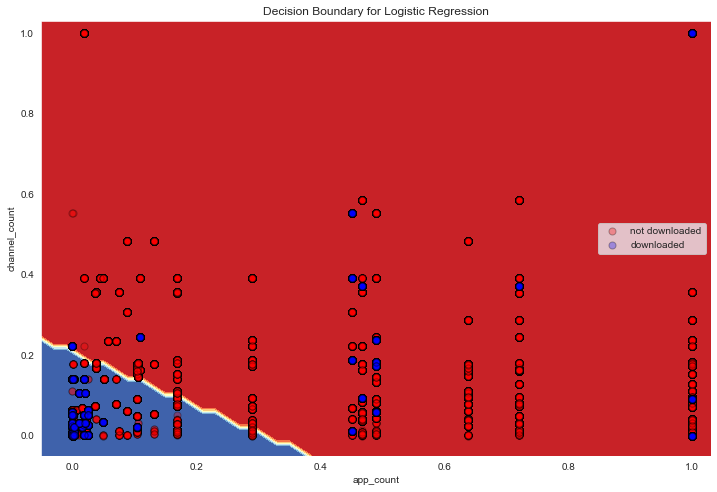

In [19]:
logreg_model = LogisticRegression(C=10)
plot_decision_boundary(logreg_model, X_train_os, y_train_os, 'Logistic Regression', (12, 8), do_pca=False, rep=0.02)

## SVM

In [89]:
def svm_alg(X, y):
    svm_model = SVC(kernel='linear', probability=True)
    svm_model.fit(X, y)
    
    y_pred = svm_model.predict(X_test)
    print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
    print('Accuracy score: ', accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    y_prob = svm_model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
    score = roc_auc_score(y_test, y_prob[:, 1])

    return fpr, tpr, score, svm_model

In [46]:
fpr_svm, tpr_svm, score_svm =svm_alg(X_train, y_train)

Confusion matrix: 
 [[19939    16]
 [   44     1]]
Accuracy score:  0.997
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19955
           1       0.06      0.02      0.03        45

    accuracy                           1.00     20000
   macro avg       0.53      0.51      0.52     20000
weighted avg       1.00      1.00      1.00     20000



In [42]:
svm_alg(X_train_ns, y_train_ns)

Confusion matrix: 
 [[  314 19641]
 [   21    24]]
Accuracy score:  0.0169
              precision    recall  f1-score   support

           0       0.94      0.02      0.03     19955
           1       0.00      0.53      0.00        45

    accuracy                           0.02     20000
   macro avg       0.47      0.27      0.02     20000
weighted avg       0.94      0.02      0.03     20000



In [43]:
# svm_alg(X_train_os, y_train_os)

In [ ]:
# svm_alg(X_train_sm, y_train_sm)

In [90]:
df_svm = pd.concat([X_train_sm, y_train_sm], axis=1)
df_svm = df_svm.sample(frac=0.1, random_state=1)

X_svm = df_svm.drop('is_attributed', axis=1)
y_svm =df_svm['is_attributed']


fpr_svm, tpr_svm, score_svm, clf_svm = svm_alg(X_svm, y_svm)

Confusion matrix: 
 [[18296  1659]
 [    5    40]]
Accuracy score:  0.9168
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     19955
           1       0.02      0.89      0.05        45

    accuracy                           0.92     20000
   macro avg       0.51      0.90      0.50     20000
weighted avg       1.00      0.92      0.95     20000



['app_count' 'channel_count']


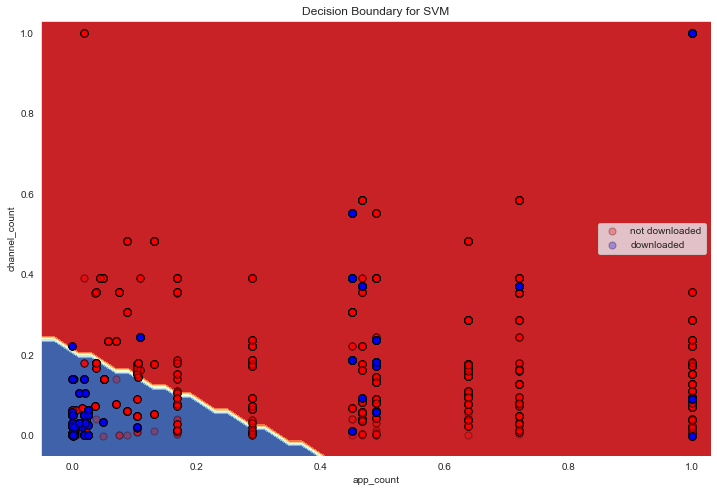

In [91]:
plot_decision_boundary(clf_svm, X_svm, y_svm, name='SVM', figsize=(12, 8))

## KNN

In [65]:
grid_knn ={
    'n_neighbors': [3, 4, 5, 11, 19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# grid_knn ={
#     'n_neighbors': np.arange(4, 15)
# }

def knn_alg(X, y):
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, grid_knn, cv=cv, n_jobs=-1, scoring='f1_macro')
    clf.fit(X, y)
    
    y_pred = clf.predict(X_test)
    print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
    print('Accuracy score: ', accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    y_prob = clf.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
    score = roc_auc_score(y_test, y_prob[:, 1])

    return fpr, tpr, score, clf

In [19]:
knn_alg(X_train, y_train)

Confusion matrix: 
 [[19944    11]
 [   43     2]]
Accuracy score:  0.9973
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19955
           1       0.15      0.04      0.07        45

    accuracy                           1.00     20000
   macro avg       0.58      0.52      0.53     20000
weighted avg       1.00      1.00      1.00     20000



In [20]:
knn_alg(X_train_ns, y_train_ns)

Confusion matrix: 
 [[ 2070 17885]
 [   20    25]]
Accuracy score:  0.10475
              precision    recall  f1-score   support

           0       0.99      0.10      0.19     19955
           1       0.00      0.56      0.00        45

    accuracy                           0.10     20000
   macro avg       0.50      0.33      0.10     20000
weighted avg       0.99      0.10      0.19     20000



In [21]:
knn_alg(X_train_os, y_train_os)

Confusion matrix: 
 [[19886    69]
 [   32    13]]
Accuracy score:  0.99495
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19955
           1       0.16      0.29      0.20        45

    accuracy                           0.99     20000
   macro avg       0.58      0.64      0.60     20000
weighted avg       1.00      0.99      1.00     20000



In [67]:
fpr_knn, tpr_knn, score_knn, clf_knn = knn_alg(X_train_sm, y_train_sm)

Confusion matrix: 
 [[19890    65]
 [   32    13]]
Accuracy score:  0.99515
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19955
           1       0.17      0.29      0.21        45

    accuracy                           1.00     20000
   macro avg       0.58      0.64      0.60     20000
weighted avg       1.00      1.00      1.00     20000



In [68]:
clf_knn.best_estimator_

KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')

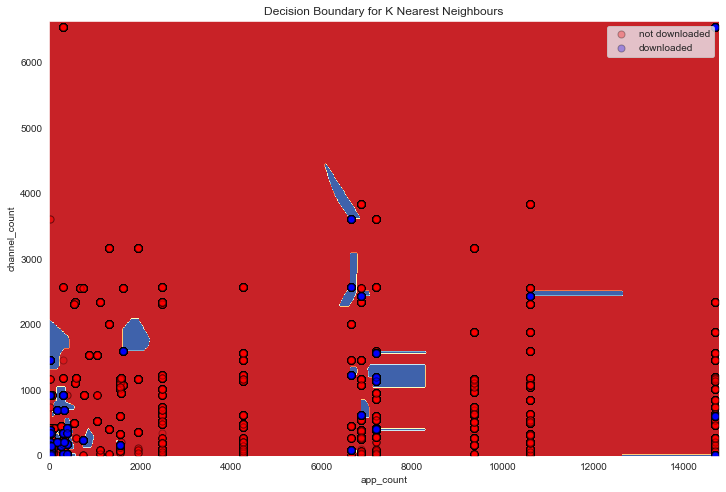

In [79]:
knn = KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')
plot_decision_boundary(knn, X_train_sm, y_train_sm, 'K Nearest Neighbours', (12, 8), do_pca=True, rep=20)

## Decision Tree

In [29]:
grid_dtc = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 10),
    'min_samples_split': range(1, 10),
    'min_samples_leaf': range(1, 5)
}

def dtc_alg(X, y):
    dtc = DecisionTreeClassifier()
    clf = GridSearchCV(dtc, grid_dtc, cv=cv, n_jobs=-1, scoring='f1_macro')
    clf.fit(X, y)
    
    y_pred = clf.predict(X_test)
    print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
    print('Accuracy score: ', accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    y_prob = clf.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
    score = roc_auc_score(y_test, y_prob[:, 1])

    return fpr, tpr, score, clf

In [24]:
dtc_alg(X_train, y_train)

Confusion matrix: 
 [[19946     9]
 [   34    11]]
Accuracy score:  0.99785
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19955
           1       0.55      0.24      0.34        45

    accuracy                           1.00     20000
   macro avg       0.77      0.62      0.67     20000
weighted avg       1.00      1.00      1.00     20000



In [25]:
dtc_alg(X_train_ns, y_train_ns)

Confusion matrix: 
 [[ 2387 17568]
 [   16    29]]
Accuracy score:  0.1208
              precision    recall  f1-score   support

           0       0.99      0.12      0.21     19955
           1       0.00      0.64      0.00        45

    accuracy                           0.12     20000
   macro avg       0.50      0.38      0.11     20000
weighted avg       0.99      0.12      0.21     20000



In [26]:
dtc_alg(X_train_os, y_train_os)

Confusion matrix: 
 [[19478   477]
 [   17    28]]
Accuracy score:  0.9753
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     19955
           1       0.06      0.62      0.10        45

    accuracy                           0.98     20000
   macro avg       0.53      0.80      0.54     20000
weighted avg       1.00      0.98      0.99     20000



In [30]:
fpr_dtc, tpr_dtc, score_dtc, clf_dtc = dtc_alg(X_train_sm, y_train_sm)

Confusion matrix: 
 [[19528   427]
 [   17    28]]
Accuracy score:  0.9778
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     19955
           1       0.06      0.62      0.11        45

    accuracy                           0.98     20000
   macro avg       0.53      0.80      0.55     20000
weighted avg       1.00      0.98      0.99     20000



In [31]:
clf_dtc.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_split=9)

['app_count' 'channel_count']


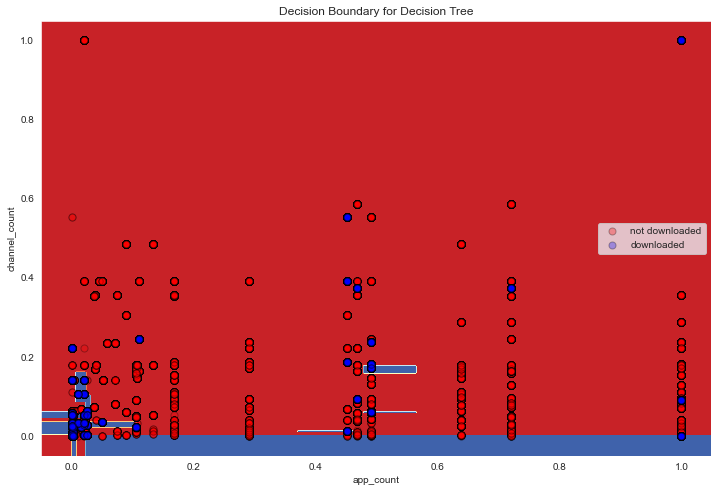

In [35]:
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_split=9)
plot_decision_boundary(dtc, X_train_sm, y_train_sm, 'Decision Tree', (12, 8), rep=0.002)

## Random Forest
Using class weight

In [86]:
class_weight = {
    0:1,
    1:10
}

In [87]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(class_weight=class_weight)
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 10})

In [88]:
y_pred = rfc.predict(X_test)
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Confusion matrix: 
 [[19954     1]
 [   40     5]]
Accuracy score:  0.99795
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19955
           1       0.83      0.11      0.20        45

    accuracy                           1.00     20000
   macro avg       0.92      0.56      0.60     20000
weighted avg       1.00      1.00      1.00     20000



## Random Forest

In [36]:
from sklearn.model_selection import RandomizedSearchCV

grid_rf = { 
    'n_estimators': [10, 100, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' :['entropy']
}

def rf(X, y):
    rfc = RandomForestClassifier()    
    clf = RandomizedSearchCV(rfc, grid_rf, cv=cv, n_jobs=-1, scoring='f1_macro')
    clf.fit(X, y)

    y_pred = clf.predict(X_test)
    print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
    print('Accuracy score: ', accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    y_prob = clf.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
    score = roc_auc_score(y_test, y_prob[:, 1])

    return fpr, tpr, score, clf

In [31]:
rf(X_train, y_train)

Confusion matrix: 
 [[19951     4]
 [   38     7]]
Accuracy score:  0.9979
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19955
           1       0.64      0.16      0.25        45

    accuracy                           1.00     20000
   macro avg       0.82      0.58      0.62     20000
weighted avg       1.00      1.00      1.00     20000



In [32]:
rf(X_train_ns, y_train_ns)

Confusion matrix: 
 [[  409 19546]
 [   15    30]]
Accuracy score:  0.02195
              precision    recall  f1-score   support

           0       0.96      0.02      0.04     19955
           1       0.00      0.67      0.00        45

    accuracy                           0.02     20000
   macro avg       0.48      0.34      0.02     20000
weighted avg       0.96      0.02      0.04     20000



In [26]:
rf(X_train_os, y_train_os)

Confusion matrix: 
 [[19938    17]
 [   35    10]]
Accuracy score:  0.9974
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19955
           1       0.37      0.22      0.28        45

    accuracy                           1.00     20000
   macro avg       0.68      0.61      0.64     20000
weighted avg       1.00      1.00      1.00     20000



In [37]:
fpr_rf, tpr_rf, score_rf, rfc = rf(X_train_sm, y_train_sm)

Confusion matrix: 
 [[19939    16]
 [   34    11]]
Accuracy score:  0.9975
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19955
           1       0.41      0.24      0.31        45

    accuracy                           1.00     20000
   macro avg       0.70      0.62      0.65     20000
weighted avg       1.00      1.00      1.00     20000



In [38]:
rfc.best_estimator_

RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       n_estimators=10)

In [41]:
score_rf

0.8627255769926779

['app_count' 'channel_count']


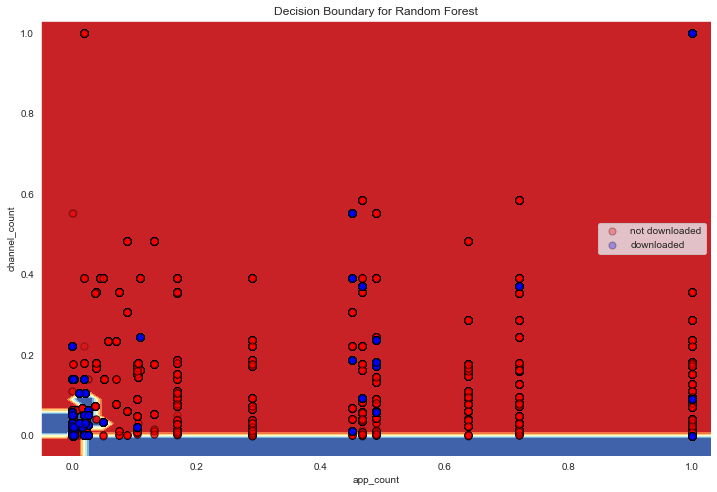

In [40]:
rfc_model = RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       n_estimators=10)
plot_decision_boundary(rfc_model, X_train_os, y_train_os, name='Random Forest', figsize=(12, 8))

## Naive Bayes

In [24]:
def gnb_alg(X, y):
    gnb = GaussianNB()
    gnb.fit(X, y)
    
    y_pred = gnb.predict(X_test)
    print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
    print('Accuracy score: ', accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    y_prob = gnb.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
    score = roc_auc_score(y_test, y_prob[:, 1])

    return fpr, tpr, score, gnb

In [36]:
gnb_alg(X_train, y_train)

Confusion matrix: 
 [[19428   527]
 [   33    12]]
Accuracy score:  0.972
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     19955
           1       0.02      0.27      0.04        45

    accuracy                           0.97     20000
   macro avg       0.51      0.62      0.51     20000
weighted avg       1.00      0.97      0.98     20000



In [37]:
gnb_alg(X_train_ns, y_train_ns)

Confusion matrix: 
 [[  634 19321]
 [   32    13]]
Accuracy score:  0.03235
              precision    recall  f1-score   support

           0       0.95      0.03      0.06     19955
           1       0.00      0.29      0.00        45

    accuracy                           0.03     20000
   macro avg       0.48      0.16      0.03     20000
weighted avg       0.95      0.03      0.06     20000



In [25]:
fpr_nb, tpr_nb, score_nb, gnb = gnb_alg(X_train_os, y_train_os)

Confusion matrix: 
 [[17376  2579]
 [    6    39]]
Accuracy score:  0.87075
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     19955
           1       0.01      0.87      0.03        45

    accuracy                           0.87     20000
   macro avg       0.51      0.87      0.48     20000
weighted avg       1.00      0.87      0.93     20000



In [44]:
gnb_alg(X_train_sm, y_train_sm)

Confusion matrix: 
 [[17295  2660]
 [    6    39]]
Accuracy score:  0.8667
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     19955
           1       0.01      0.87      0.03        45

    accuracy                           0.87     20000
   macro avg       0.51      0.87      0.48     20000
weighted avg       1.00      0.87      0.93     20000



(array([0.00000000e+00, 5.01127537e-05, 5.51240291e-04, 5.51240291e-04,
        1.45326986e-03, 1.45326986e-03, 1.50338261e-03, 1.50338261e-03,
        2.75620145e-03, 2.75620145e-03, 2.85642696e-03, 2.85642696e-03,
        3.50789276e-03, 3.50789276e-03, 3.70834377e-03, 3.70834377e-03,
        3.95890754e-03, 3.95890754e-03, 4.35980957e-03, 4.35980957e-03,
        4.71059885e-03, 4.71059885e-03, 5.91330494e-03, 5.91330494e-03,
        2.76121273e-02, 2.76121273e-02, 2.77123528e-02, 2.77123528e-02,
        2.79128038e-02, 2.79128038e-02, 2.83137058e-02, 2.83137058e-02,
        2.94662992e-02, 2.94662992e-02, 3.07191180e-02, 3.07191180e-02,
        3.21723879e-02, 3.21723879e-02, 3.38762215e-02, 3.38762215e-02,
        4.20947131e-02, 4.20947131e-02, 4.73064395e-02, 4.73064395e-02,
        4.99123027e-02, 4.99123027e-02, 4.99624154e-02, 4.99624154e-02,
        5.04134302e-02, 5.04134302e-02, 5.46730143e-02, 5.46730143e-02,
        5.91831621e-02, 5.91831621e-02, 6.32422952e-02, 6.324229

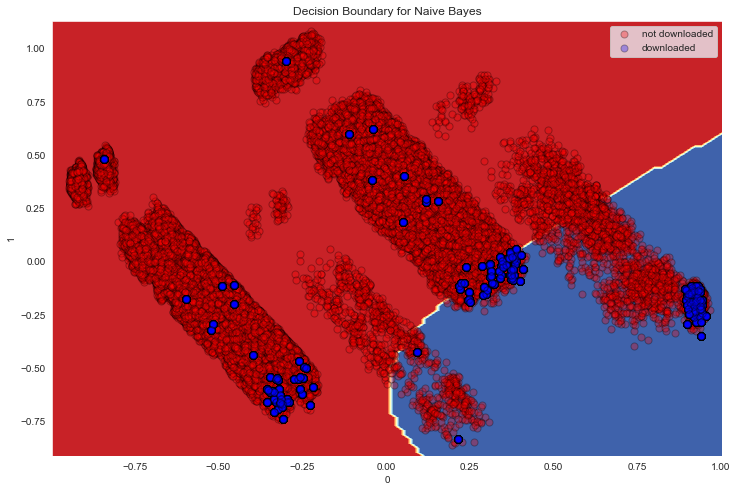

In [24]:
plot_decision_boundary(gnb, X_train_os, y_train_os, name='Naive Bayes', figsize=(12, 8), do_pca=True)

### ROC-AUC

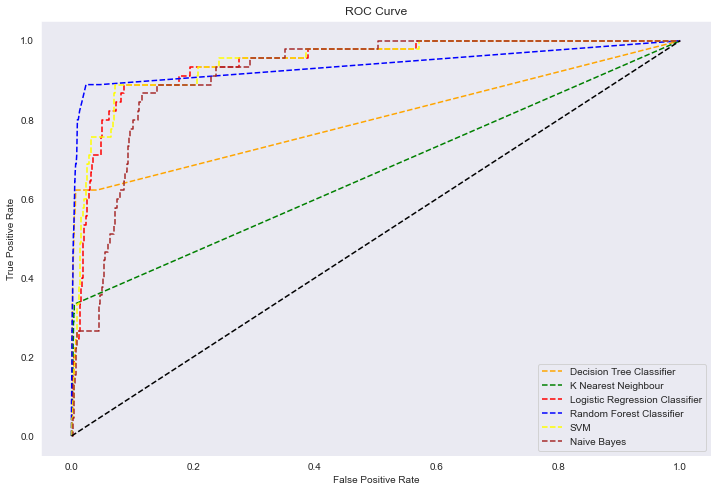

In [93]:
random_probs = [0 for i in range(len(y_test))]
fpr_r, tpr_r, _ = roc_curve(y_test, random_probs)

plt.figure(figsize=(12, 8))
plt.plot(fpr_dtc, tpr_dtc, linestyle='--', color='orange', label='Decision Tree Classifier')
plt.plot(fpr_knn, tpr_knn, linestyle='--', color='green', label='K Nearest Neighbour')
plt.plot(fpr_logreg, tpr_logreg, linestyle='--', color='red', label='Logistic Regression Classifier')
plt.plot(fpr_rf, tpr_rf, linestyle='--', color='blue', label='Random Forest Classifier')
plt.plot(fpr_svm, tpr_svm, linestyle='--', color='yellow', label='SVM')
plt.plot(fpr_nb, tpr_nb, linestyle='--', color='brown', label='Naive Bayes')
plt.plot(fpr_r, tpr_r, linestyle='--', color='black')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

In [92]:
print('AUC')
print('Logistic Regression: ', score_logreg)
print('Decision Tree: ', score_dtc)
print('KNearestNeighbours: ', score_knn)
print('Naive Bayes: ', score_nb)
print('Random Forest: ', score_rf)
print('SVM: ', score_svm)

AUC
Logistic Regression:  0.9425718978813441
Decision Tree:  0.8019098527241849
KNearestNeighbours:  0.6644745120966619
Naive Bayes:  0.9146423898215429
Random Forest:  0.9378702079679279
SVM:  0.9448882207188396
